In [1]:
import json
import torch
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd


/raid/s3/opengptx/mehdi/git_repos/edu_filter/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaModel.from_pretrained('roberta-base').to(device)

/raid/s3/opengptx/mehdi/git_repos/edu_filter/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Function to embed text using RoBERTa
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :].cpu().squeeze().numpy()

In [4]:
# Read JSONL file and extract text data
def read_jsonl(file_path):
    documents = []
    with open(file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line)
            if 'text' in json_obj:
                documents.append(json_obj['text'])
    return documents

In [14]:
# Visualize embeddings in 2D plot
def visualize_embeddings(embeddings, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method for dimensionality reduction: choose 'pca' or 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Convert to a DataFrame for easier plotting
    df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(df['Component 1'], df['Component 2'], c='blue', alpha=0.5)
    plt.title(f'2D Visualization of Text Embeddings ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    # Save the plot as a PNG file
    plt.show()  

Loaded 1000 documents from /raid/s3/opengptx/mehdi/git_repos/edu_filter/notebooks/../data/1000_documents.json


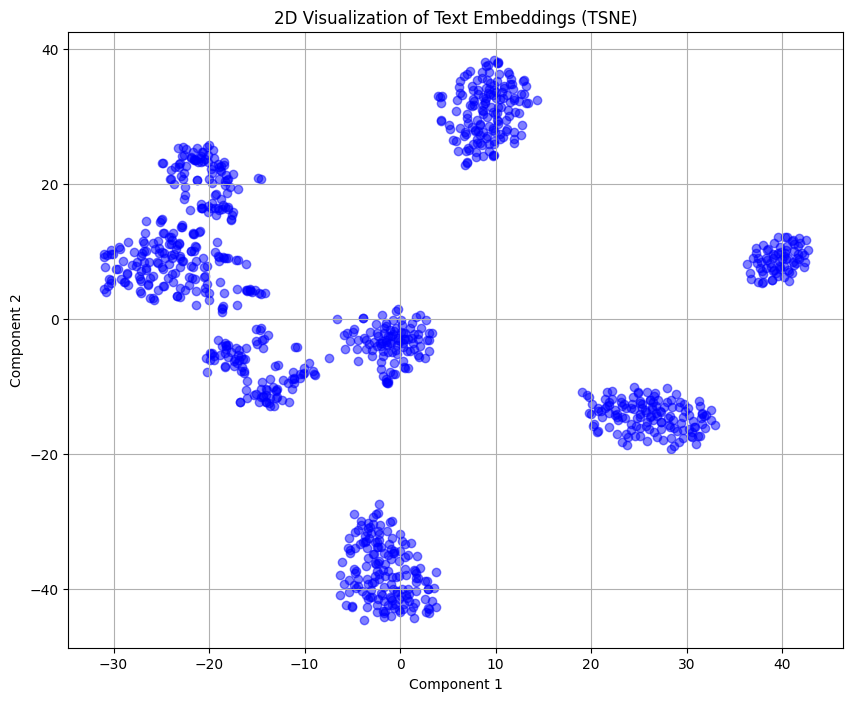

In [15]:
import os
HERE = os.getcwd()
# Path to the JSONL file
jsonl_file = os.path.join(HERE,os.pardir,"data","1000_documents.json")  

# Step 1: Read the JSONL file
documents = read_jsonl(jsonl_file)
print(f"Loaded {len(documents)} documents from {jsonl_file}")

# Step 2: Embed each document's text
embeddings = []
for text in documents:
    embeddings.append(embed_text(text))

embeddings = torch.tensor(embeddings)  # Convert list to tensor

# Step 3: Visualize the embeddings in 2D
visualize_embeddings(embeddings, method='tsne')  # Choose either 'pca' or 'tsne'
